Heart Failure CatBoost, CV, robust 87% accuracy

In [1]:
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier

In [9]:
df = pd.read_csv('./input/heart.csv')
print(df.shape)

(918, 12)


In [10]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [12]:
#Determine data points with NaN, None, NaT
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [13]:
#Determine reduntant data points
df.duplicated().sum()

0

In [14]:
#Remove numerical data with unvalid 0 values
df = df[df.Cholesterol != 0]
df = df[df.RestingBP != 0]

print(df.shape)

(746, 12)


In [15]:
numerical = df.drop(['HeartDisease'], axis=1).select_dtypes('number').columns
print(f'Numerical Columns:  {df[numerical].columns}')

Numerical Columns:  Index(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak'], dtype='object')


In [16]:
categorical = df.select_dtypes('object').columns
print(f'Categorical Columns: {df[categorical].columns}\n')
# n unique categories
df[categorical].nunique()

Categorical Columns: Index(['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], dtype='object')



Sex               2
ChestPainType     4
RestingECG        3
ExerciseAngina    2
ST_Slope          3
dtype: int64

In [17]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000
mean,52.882038,133.022788,244.635389,0.167560,140.226542,0.901609,0.477212
std,9.505888,17.282750,59.153524,0.373726,24.524107,1.072861,0.499816
min,28.000000,92.000000,85.000000,0.000000,69.000000,-0.100000,0.000000
25%,46.000000,120.000000,207.250000,0.000000,122.000000,0.000000,0.000000
50%,54.000000,130.000000,237.000000,0.000000,140.000000,0.500000,0.000000
75%,59.000000,140.000000,275.000000,0.000000,160.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'RestingBP'}>,
        <AxesSubplot:title={'center':'Cholesterol'}>],
       [<AxesSubplot:title={'center':'FastingBS'}>,
        <AxesSubplot:title={'center':'MaxHR'}>,
        <AxesSubplot:title={'center':'Oldpeak'}>],
       [<AxesSubplot:title={'center':'HeartDisease'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

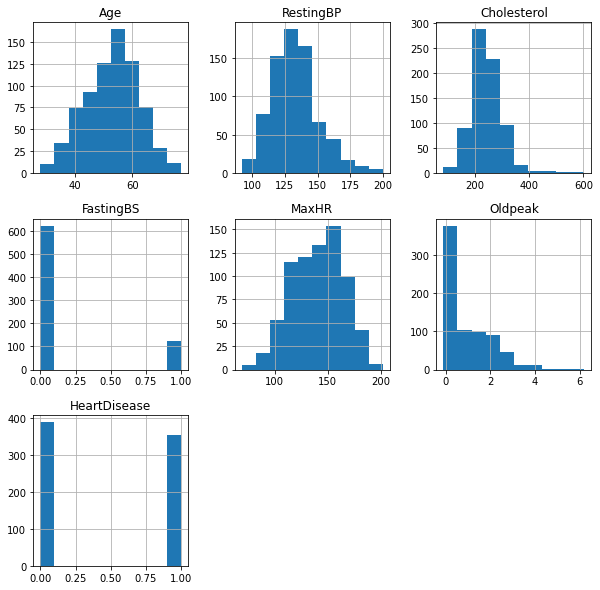

In [18]:
df.hist(figsize=(10,10))

<AxesSubplot:>

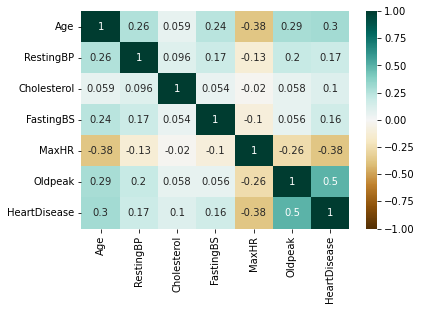

In [19]:
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')

<AxesSubplot:xlabel='Age', ylabel='MaxHR'>

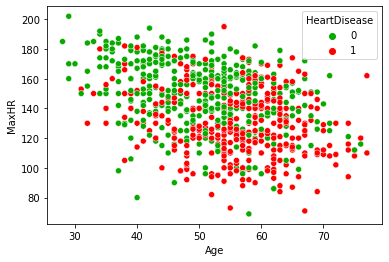

In [20]:
#MaxHR decreases with age && heart disease increases with lower MaxHR
# set colors for heartdisease
colors = ['#09AA00', '#ff0000']
sns.scatterplot(x="Age", y="MaxHR", hue="HeartDisease", data=df, palette=colors)

<AxesSubplot:xlabel='Age', ylabel='RestingBP'>

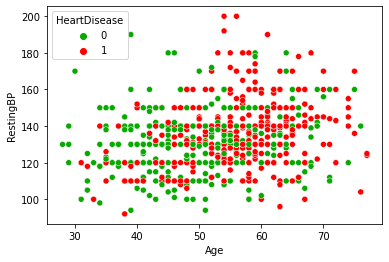

In [21]:
#The resting blood pressure increases with age
sns.scatterplot(x="Age", y="RestingBP", hue="HeartDisease",data=df, palette=colors)

<AxesSubplot:xlabel='Age', ylabel='Oldpeak'>

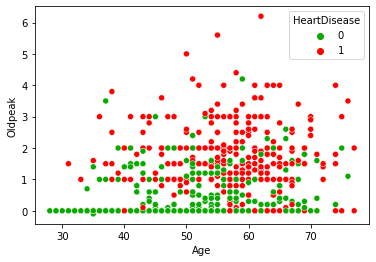

In [22]:
#Heart disease increases with higher Oldpeak
sns.scatterplot(x="Age", y="Oldpeak", hue="HeartDisease" ,data=df, palette=colors)

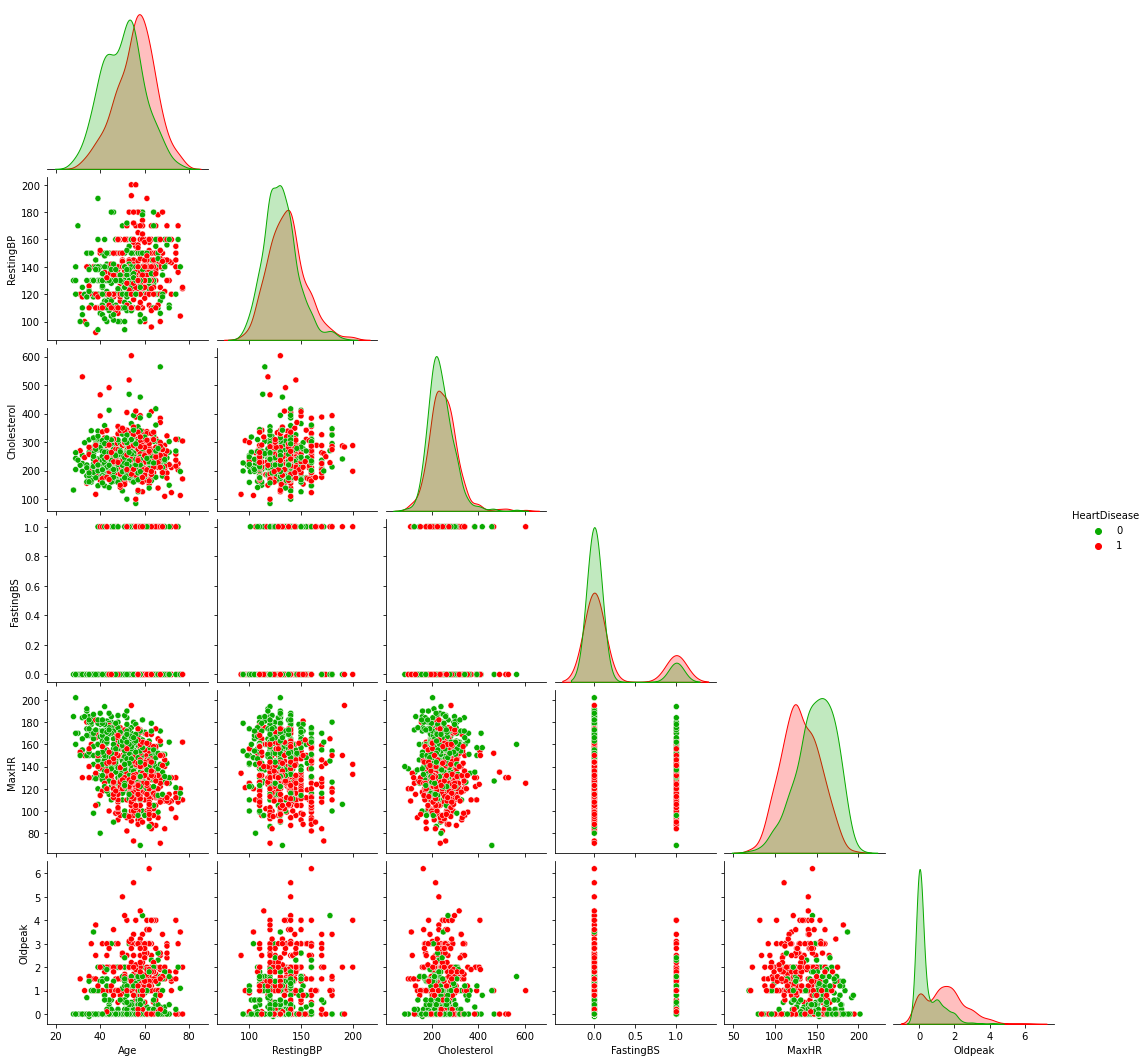

In [23]:
#Print all numerical features on a pair plot
sns.pairplot(df, hue="HeartDisease", corner=True, palette=colors)

<AxesSubplot:xlabel='Sex', ylabel='Age'>

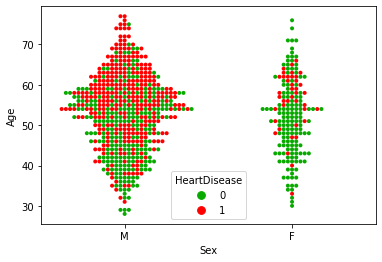

In [24]:
#Men more susceptible with older age
sns.swarmplot(y="Age", x="Sex", hue="HeartDisease", data=df, s=4, palette=colors)

<AxesSubplot:xlabel='RestingECG', ylabel='Age'>

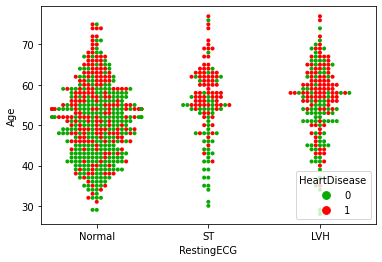

In [25]:
#Print the resting EKG
sns.swarmplot(y='Age', x='RestingECG', hue="HeartDisease", data=df, s=4, palette=colors)

<AxesSubplot:xlabel='ChestPainType', ylabel='Age'>

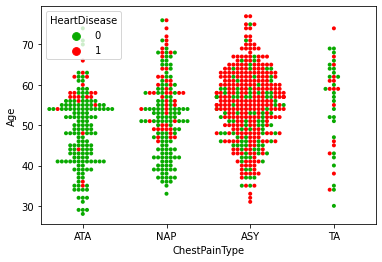

In [26]:
#Print the chest pain type => ASY strong correlation
sns.swarmplot(y="Age", x="ChestPainType", hue="HeartDisease", data=df, s=4, palette=colors)

<AxesSubplot:xlabel='ST_Slope', ylabel='Age'>

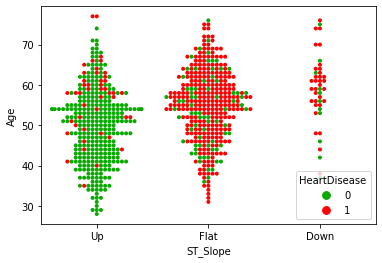

In [27]:
#Print the ST_Slope => FLAT strong correlation
sns.swarmplot(y="Age", x="ST_Slope", hue="HeartDisease", data=df, s=4, palette=colors)

<AxesSubplot:xlabel='ExerciseAngina', ylabel='Age'>

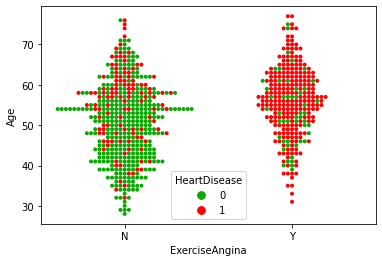

In [28]:
#Print influence of stress-dependent angina pectoris => YES strong correlation

sns.swarmplot(y="Age", x="ExerciseAngina", hue="HeartDisease", data=df, s=4, palette=colors)

In [29]:
# determine categorical features
categ = df.select_dtypes(include=object).columns
print(categ)
# convert categorical features to numeric
df = pd.get_dummies(df, columns=categ, drop_first=True)

df.head()

Index(['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], dtype='object')


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,1,1,0,0,1,0,0,0,1
1,49,160,180,0,156,1.0,1,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0.0,0,1,1,0,0,0,1,0,0,1
3,48,138,214,0,108,1.5,1,0,0,0,0,1,0,1,1,0
4,54,150,195,0,122,0.0,0,1,0,1,0,1,0,0,0,1


In [30]:
y, X = df['HeartDisease'], df.drop(columns='HeartDisease')

In [31]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

0    390
1    356
Name: HeartDisease, dtype: int64
0    390
1    390
Name: HeartDisease, dtype: int64


Text(0.5, 1.0, 'HeartDiseases')

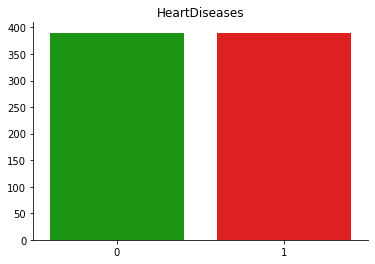

In [32]:
# print unbalanced classes 
labels_count = y.value_counts()
print(labels_count)

# oversample minority class with SMOTE
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

# print balanced classes 
labels_count = y.value_counts()
print(labels_count)

# plot HeartDisease
s = sns.barplot(x=labels_count.index, y=labels_count.values, palette=colors)
sns.despine()
s.set_xticklabels(s.get_xticklabels())
s.set_title('HeartDiseases')

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(702, 15)
(78, 15)
(702,)
(78,)


In [34]:
# stratisfied k cross-validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# create model with default hyperparameters
model = CatBoostClassifier()
# run cross validation
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="accuracy")

Learning rate set to 0.008463
0:	learn: 0.6861785	total: 50.6ms	remaining: 50.5s
1:	learn: 0.6799404	total: 51.8ms	remaining: 25.8s
2:	learn: 0.6737686	total: 52.8ms	remaining: 17.5s
3:	learn: 0.6669175	total: 53.8ms	remaining: 13.4s
4:	learn: 0.6619461	total: 54.7ms	remaining: 10.9s
5:	learn: 0.6547129	total: 55.6ms	remaining: 9.22s
6:	learn: 0.6483305	total: 56.6ms	remaining: 8.04s
7:	learn: 0.6444256	total: 57ms	remaining: 7.06s
8:	learn: 0.6383023	total: 57.8ms	remaining: 6.36s
9:	learn: 0.6330602	total: 58.4ms	remaining: 5.78s
10:	learn: 0.6277294	total: 59.3ms	remaining: 5.33s
11:	learn: 0.6217949	total: 60.1ms	remaining: 4.95s
12:	learn: 0.6151316	total: 60.9ms	remaining: 4.62s
13:	learn: 0.6102357	total: 61.7ms	remaining: 4.34s
14:	learn: 0.6056549	total: 62.5ms	remaining: 4.1s
15:	learn: 0.5998149	total: 63.3ms	remaining: 3.89s
16:	learn: 0.5953661	total: 64.2ms	remaining: 3.71s
17:	learn: 0.5900432	total: 65ms	remaining: 3.55s
18:	learn: 0.5850428	total: 65.8ms	remaining: 3.4

In [35]:
print("Accuracy:", scores.mean())
print("Std:", scores.std())

Accuracy: 0.8742253521126759
Std: 0.04010501183384159


In [36]:
model.fit(X_train, y_train)

Learning rate set to 0.008858
0:	learn: 0.6857188	total: 1.17ms	remaining: 1.17s
1:	learn: 0.6791162	total: 2.42ms	remaining: 1.21s
2:	learn: 0.6727098	total: 3.39ms	remaining: 1.13s
3:	learn: 0.6653685	total: 4.36ms	remaining: 1.08s
4:	learn: 0.6600756	total: 5.28ms	remaining: 1.05s
5:	learn: 0.6524557	total: 6.19ms	remaining: 1.02s
6:	learn: 0.6457584	total: 7.08ms	remaining: 1s
7:	learn: 0.6417854	total: 7.38ms	remaining: 915ms
8:	learn: 0.6346442	total: 8.31ms	remaining: 915ms
9:	learn: 0.6283621	total: 9.18ms	remaining: 909ms
10:	learn: 0.6221403	total: 10ms	remaining: 903ms
11:	learn: 0.6185689	total: 10.3ms	remaining: 852ms
12:	learn: 0.6123158	total: 11.2ms	remaining: 850ms
13:	learn: 0.6066296	total: 12.1ms	remaining: 853ms
14:	learn: 0.6012343	total: 13ms	remaining: 853ms
15:	learn: 0.5957883	total: 13.9ms	remaining: 855ms
16:	learn: 0.5902609	total: 14.8ms	remaining: 854ms
17:	learn: 0.5845817	total: 15.7ms	remaining: 856ms
18:	learn: 0.5788650	total: 16.6ms	remaining: 857ms